### MDI usando Regresión Logistica

In [ ]:
import pandas as pd
import numpy as np
from typing import List, Tuple, Union, Optional
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import joblib
import glob

### Obtención de rutas a través de Glob

In [ ]:
def get_routes(imbalance_folder: str, misalignment_folder: str = None) -> List[str]:
  imbalance_path = glob.glob(f"{imbalance_folder}/*.csv")
  if misalignment_folder is None:
    return imbalance_path
  else:
    misalignment_path = glob.glob(f"{misalignment_folder}/*.csv")
    return imbalance_path + misalignment_path

In [ ]:
# Obtención de las rutas de los archivos .csv
imbalance_folder = "/content/drive/MyDrive/desbalanceo/data_processed"
# misalignment_folder = "/content/drive/MyDrive/desalineacion/data_processed"
misalignment_folder = None
file_paths = get_routes(imbalance_folder, misalignment_folder)
file_paths

['/content/drive/MyDrive/desbalanceo/data_processed/1_arranqueParadaDesblnCILCIP_procesado.csv',
 '/content/drive/MyDrive/desbalanceo/data_processed/2_arranqueParadaDesblnCILCIP_procesado.csv',
 '/content/drive/MyDrive/desbalanceo/data_processed/5_paradaDesblnCILCIP_procesado.csv',
 '/content/drive/MyDrive/desbalanceo/data_processed/6_paradaDesblnCSPCSL_procesado.csv',
 '/content/drive/MyDrive/desbalanceo/data_processed/7_paradaDesblnCSPCSL_procesado.csv',
 '/content/drive/MyDrive/desbalanceo/data_processed/8_paradaDesblnCSPCSL_procesado.csv',
 '/content/drive/MyDrive/desbalanceo/data_processed/9_paradaDesblnCSPCSL_procesado.csv',
 '/content/drive/MyDrive/desbalanceo/data_processed/10_paradaDesblnCSPCSL_procesado.csv',
 '/content/drive/MyDrive/desbalanceo/data_processed/11_paradaDesblnCSLCSPCTP_procesado.csv',
 '/content/drive/MyDrive/desbalanceo/data_processed/4_arranqueParadaDesblnCSLCSPCTP_procesado.csv',
 '/content/drive/MyDrive/desbalanceo/data_processed/14_paradaDesblnCSLCSPCTP_p

### Pipeline de calculo de residuos

In [ ]:
class DataResidualsProcessor:
    """
    Clase para procesar datos, ajustar modelos polinómicos y calcular residuos.

    #calc-res: Versión 1.3
    - Se entrena sobre un DataFrame de entrenamiento para obtener un ajuste que represente
      el comportamiento de desbalanceo.
    - El objeto resultante guarda los modelos, la transformación polinómica, las columnas de
      desplazamiento y un umbral basado en el percentil del error medio absoluto.
    - Luego se utiliza este ajuste para calcular los residuos en nuevos datos sin reentrenar.
    - Incluye métodos para guardar y cargar el objeto entrenado (el "mejor ajuste").
    """

    def __init__(self, degree: int = 3, speed_col: str = 'KPH', threshold_percentile: float = 90.0):
        """
        Inicializa el procesador.

        Parámetros:
          - degree: Grado del polinomio para el modelo.
          - speed_col: Nombre de la columna de velocidad.
          - threshold_percentile: Percentil para definir el umbral basado en el error medio absoluto.
        """
        self.degree = degree
        self.speed_col = speed_col
        self.threshold_percentile = threshold_percentile
        self.poly = PolynomialFeatures(degree=self.degree)
        self.models = {}  # Diccionario para almacenar el modelo de cada columna de desplazamiento.
        self.displacement_cols = None  # Se definirá al extraer las columnas.
        self.df_train = None  # DataFrame de entrenamiento.
        self.threshold = None  # Umbral calculado a partir de los residuos de entrenamiento.

    def _load_data(self, ruta_archivo: str = None, df: pd.DataFrame = None) -> pd.DataFrame:
        """
        Carga los datos desde un DataFrame o desde una ruta de archivo.
        Se asume que el archivo ya está preprocesado.
        """
        if df is not None:
            return df
        elif ruta_archivo is not None:
            try:
                df_loaded = pd.read_csv(ruta_archivo, delimiter=",")
                return df_loaded
            except Exception as e:
                raise ValueError(f"No se pudo leer el archivo {ruta_archivo}: {e}")
        else:
            raise ValueError("Se debe proporcionar un DataFrame o una ruta de archivo.")

    def _get_displacement_cols(self, df: pd.DataFrame) -> List[str]:
        """
        Obtiene las columnas de desplazamiento a partir del DataFrame,
        descartando 'Fecha' y la columna de velocidad.
        """
        columnas = [col for col in df.columns if col not in ['Fecha', self.speed_col]]
        if not columnas:
            raise ValueError("No se encontraron columnas de desplazamiento válidas.")
        return columnas

    def fit(self, df: pd.DataFrame = None, ruta_archivo: str = None) -> 'DataResidualsProcessor':
        """
        Ajusta los modelos de regresión polinómica usando los datos de entrenamiento (desbalanceo)
        y calcula un umbral basado en el percentil del error medio absoluto.

        Se recomienda pasar un DataFrame (que puede ser la concatenación de varios archivos) o
        un archivo preprocesado para obtener un ajuste global.
        """
        # Cargar datos de entrenamiento
        self.df_train = self._load_data(ruta_archivo, df)
        # Extraer columnas de desplazamiento
        self.displacement_cols = self._get_displacement_cols(self.df_train)
        # Transformar la velocidad en funciones polinómicas
        kph = self.df_train[self.speed_col].values.reshape(-1, 1)
        X_poly = self.poly.fit_transform(kph)

        # Ajustar un modelo para cada columna de desplazamiento
        for col in self.displacement_cols:
            y = self.df_train[col].values
            model = LinearRegression()
            model.fit(X_poly, y)
            self.models[col] = model

        # Calcular los residuos en el conjunto de entrenamiento
        residuals = []
        for col in self.displacement_cols:
            y = self.df_train[col].values
            y_pred = self.models[col].predict(X_poly)
            resid = y - y_pred
            residuals.append(resid)
        # Combinar los residuos en una matriz (n_muestras x n_ejes)
        residuals_matrix = np.column_stack(residuals)
        # Calcular el error medio absoluto por muestra
        mean_abs_resid = np.mean(np.abs(residuals_matrix), axis=1)
        # Definir el umbral como el percentil especificado
        self.threshold = np.percentile(mean_abs_resid, self.threshold_percentile)
        print(f"Threshold (percentil {self.threshold_percentile}): {self.threshold}")
        return self

    def calculate_residuals_global(self, df: pd.DataFrame = None, ruta_archivo: str = None) -> Tuple[np.ndarray, List[str], np.ndarray, np.ndarray, np.ndarray]:
        """
        Calcula los residuos en nuevos datos utilizando el modelo de referencia (el "mejor modelo")
        guardado en el objeto. Esta función ignora las diferencias en nombres o cantidad de columnas;
        para cada sensor (columna) en el archivo nuevo (todas las columnas que no sean 'Fecha' ni la velocidad),
        se aplica el mismo modelo (el mejor modelo entrenado) para calcular la predicción y el residuo.

        Retorna:
          - residuals_matrix: Matriz de residuos (n_muestras, n_sensores) calculada usando el mejor modelo para cada sensor.
          - new_sensor_cols: Lista de nombres de los sensores (columnas) del nuevo archivo.
          - kph: Arreglo de la velocidad (KPH) en forma (n_muestras, 1).
          - original_matrix: Matriz con los datos originales de cada sensor.
          - predictions_matrix: Matriz con las predicciones del modelo de referencia (aplicada a cada sensor).
        """
        # Cargar los datos del archivo nuevo
        data = self._load_data(ruta_archivo, df)
        # Extraer la columna de velocidad y transformarla
        kph = data[self.speed_col].values.reshape(-1, 1)
        X_poly = self.poly.transform(kph)

        # Obtener todas las columnas de sensor en el nuevo archivo (ignorando 'Fecha' y la velocidad)
        new_sensor_cols = [col for col in data.columns if col not in ['Fecha', self.speed_col]]

        # Seleccionamos el mejor modelo de referencia.
        # Se asume que el objeto guardado (por ejemplo, de select_best_fit) ya contiene
        # un conjunto de modelos; usaremos el del primer sensor entrenado como modelo de referencia.
        best_sensor = self.displacement_cols[0]
        best_model = self.models[best_sensor]
        print(f"Usando el modelo de referencia del sensor: {best_sensor}")

        # Para cada sensor nuevo, aplicamos el mismo modelo de referencia
        residuals_list = []
        predictions_list = []
        original_list = []

        for col in new_sensor_cols:
            y_real = data[col].values
            # Usar el modelo de referencia para predecir la señal esperada
            y_pred = best_model.predict(X_poly)
            resid = y_real - y_pred
            residuals_list.append(resid)
            predictions_list.append(y_pred)
            original_list.append(y_real)

        # Armar las matrices de salida
        residuals_matrix = np.column_stack(residuals_list)
        predictions_matrix = np.column_stack(predictions_list)
        original_matrix = np.column_stack(original_list)

        return residuals_matrix, new_sensor_cols, kph, original_matrix, predictions_matrix


    def stack_residuals(self, residuals: Union[np.ndarray, List[np.ndarray]]) -> np.ndarray:
        """
        Apila todas las columnas de residuos (o una lista de arreglos) en un vector 1D.

        Args:
          - residuals: Matriz de residuos (n_muestras, n_columnas) o lista de matrices.

        Retorna:
          - np.ndarray: Arreglo 1D con todos los residuos apilados.

        #calc-res: Método auxiliar para combinar residuos.
        """
        if isinstance(residuals, list):
            if not residuals:
                raise ValueError("La lista de residuos está vacía.")
            return np.concatenate([r.flatten() for r in residuals])
        elif isinstance(residuals, np.ndarray):
            if len(residuals.shape) != 2:
                raise ValueError("El arreglo de residuos debe ser 2D (muestras, columnas).")
            return residuals.flatten()
        else:
            raise ValueError("La entrada debe ser un arreglo NumPy o una lista de arreglos.")

    def save(self, file_path: str) -> None:
        """
        Guarda el objeto entrenado (incluyendo poly, modelos, columnas y threshold) en el archivo especificado.
        """
        joblib.dump(self, file_path)
        print(f"Modelo guardado en: {file_path}")

    @classmethod
    def load(cls, file_path: str) -> 'DataResidualsProcessor':
        """
        Carga el objeto entrenado desde un archivo.

        Gracias a @classmethod, se puede llamar sin necesidad de una instancia previa:
            processor = DataResidualsProcessor.load("ruta_al_modelo.pkl")
        """
        return joblib.load(file_path)

In [ ]:
def select_best_fit(file_paths: List[str], degree: int = 3, speed_col: str = 'KPH', threshold_percentile: float = 90.0) -> DataResidualsProcessor:
    """
    Para cada archivo en file_paths, entrena un modelo candidato (DataResidualsProcessor) y calcula el error promedio
    (media del error absoluto) para cada sensor (columna de desplazamiento). Se selecciona el sensor con el error
    promedio mínimo entre todos los archivos. Se crea un objeto DataResidualsProcessor que se basa únicamente en ese sensor.

    Retorna:
      - Una instancia de DataResidualsProcessor que contiene el modelo (regresión lineal) entrenado para el mejor sensor,
        la lista de columnas (una sola, el sensor seleccionado), el objeto polinómico y el umbral (calculado sobre ese sensor).
    """
    best_candidate = None
    best_error = float('inf')
    best_sensor = None
    best_df_train = None
    best_poly = None
    best_model_for_sensor = None

    for path in file_paths:
        print(f"Entrenando ajuste en {path}...")
        # Entrena un candidato usando todos los sensores disponibles en el archivo
        candidate = DataResidualsProcessor(degree=degree, speed_col=speed_col, threshold_percentile=threshold_percentile)
        candidate.fit(ruta_archivo=path)
        # Preparar datos para calcular el error en candidate.df_train
        kph = candidate.df_train[candidate.speed_col].values.reshape(-1, 1)
        X_poly = candidate.poly.transform(kph)
        for sensor in candidate.displacement_cols:
            y = candidate.df_train[sensor].values
            y_pred = candidate.models[sensor].predict(X_poly)
            error = np.mean(np.abs(y - y_pred))
            print(f"Archivo: {path}, Sensor: {sensor} - Error promedio: {error:.4f}")
            if error < best_error:
                best_error = error
                best_sensor = sensor
                best_df_train = candidate.df_train.copy()
                best_poly = candidate.poly  # Se conserva el objeto de transformación polinómica
                best_model_for_sensor = candidate.models[sensor]
    print(f"\nMejor sensor seleccionado: {best_sensor} con error promedio: {best_error:.4f}")

    # Construir un nuevo DataResidualsProcessor basado únicamente en el sensor seleccionado
    best_candidate = DataResidualsProcessor(degree=degree, speed_col=speed_col, threshold_percentile=threshold_percentile)
    best_candidate.df_train = best_df_train
    best_candidate.poly = best_poly
    best_candidate.displacement_cols = [best_sensor]  # Solo el mejor sensor
    best_candidate.models = {best_sensor: best_model_for_sensor}

    # Recalcular el umbral usando únicamente los residuos de ese sensor
    kph = best_candidate.df_train[best_candidate.speed_col].values.reshape(-1, 1)
    X_poly = best_candidate.poly.transform(kph)
    y = best_candidate.df_train[best_sensor].values
    y_pred = best_candidate.models[best_sensor].predict(X_poly)
    resid = np.abs(y - y_pred)
    best_candidate.threshold = np.percentile(resid, threshold_percentile)
    print(f"Umbral recalculado para el sensor {best_sensor} (percentil {threshold_percentile}%): {best_candidate.threshold:.4f}")

    return best_candidate


### Guardando el mejor ajuste

In [ ]:
best_processor = select_best_fit(file_paths, degree=3, speed_col='KPH', threshold_percentile=90.0)
best_processor.save("modelo_mejor_fit.pkl")

Entrenando ajuste en /content/drive/MyDrive/desbalanceo/data_processed/1_arranqueParadaDesblnCILCIP_procesado.csv...
Threshold (percentil 90.0): 0.043596656116807575
Archivo: /content/drive/MyDrive/desbalanceo/data_processed/1_arranqueParadaDesblnCILCIP_procesado.csv, Sensor: CSP - Error promedio: 0.0119
Archivo: /content/drive/MyDrive/desbalanceo/data_processed/1_arranqueParadaDesblnCILCIP_procesado.csv, Sensor: CSL - Error promedio: 0.0127
Archivo: /content/drive/MyDrive/desbalanceo/data_processed/1_arranqueParadaDesblnCILCIP_procesado.csv, Sensor: CIP - Error promedio: 0.0118
Archivo: /content/drive/MyDrive/desbalanceo/data_processed/1_arranqueParadaDesblnCILCIP_procesado.csv, Sensor: CIL - Error promedio: 0.0119
Archivo: /content/drive/MyDrive/desbalanceo/data_processed/1_arranqueParadaDesblnCILCIP_procesado.csv, Sensor: CTP - Error promedio: 0.0122
Archivo: /content/drive/MyDrive/desbalanceo/data_processed/1_arranqueParadaDesblnCILCIP_procesado.csv, Sensor: CTL - Error promedio: 0

In [ ]:
processor = DataResidualsProcessor.load("modelo_mejor_fit.pkl")

In [ ]:
processor.displacement_cols

['CSL']

In [ ]:
for model_name, model in processor.models.items():
  print(model_name)
  print(model)

CSL
LinearRegression()


In [ ]:
processor.poly

PolynomialFeatures(degree=3)

In [ ]:
processor.threshold

np.float64(0.008002114598774493)

In [ ]:
residuos, columnas, kph, datos_originales, predicciones = processor.calculate_residuals_global(ruta_archivo=file_paths[0])

Usando el modelo de referencia del sensor: CSL


In [ ]:
residuos.shape

(266, 6)

### Clasificación binaria de residuos

In [ ]:
def compute_mean_residues(processor: DataResidualsProcessor, file_paths: List[str]) -> np.ndarray:
    """
    Calcula el residuo absoluto medio para cada archivo en file_paths,
    usando el 'processor' preentrenado (el mejor ajuste).

    Args:
        processor (DataResidualsProcessor): Objeto preentrenado.
        file_paths (List[str]): Lista de rutas a archivos CSV.

    Returns:
        np.ndarray: Arreglo 1D con el residuo medio de cada archivo.
    """
    mean_residues = []

    for path in file_paths:
        # Calcular la matriz de residuos (n_muestras, n_sensores)
        res_matrix, cols, kph, original, predictions = processor.calculate_residuals_global(ruta_archivo=path)
        # Residuo absoluto
        abs_res = np.abs(res_matrix)
        # Promediar sobre todas las muestras y sensores
        mean_val = abs_res.mean()
        mean_residues.append(mean_val)

    return np.array(mean_residues)

In [ ]:
def compute_thresholds_from_files(
    file_paths: List[str],
    processor: DataResidualsProcessor,
    lower_percentile: float = 25,
    upper_percentile: float = 75
) -> Tuple[float, float]:
    """
    Calcula los umbrales inferior y superior a partir de la distribución de los residuos medios
    de una lista de archivos.

    Args:
        file_paths (List[str]): Lista de rutas a archivos CSV.
        processor (DataResidualsProcessor): Objeto preentrenado.
        lower_percentile (float): Percentil inferior (por defecto 25).
        upper_percentile (float): Percentil superior (por defecto 75).

    Returns:
        Tuple[float, float]: (lower_threshold, upper_threshold)
    """
    mean_residues = compute_mean_residues(processor, file_paths)
    lower_threshold = np.percentile(mean_residues, lower_percentile)
    upper_threshold = np.percentile(mean_residues, upper_percentile)
    print(f"Lower threshold (percentile {lower_percentile}%): {lower_threshold:.4f}")
    print(f"Upper threshold (percentile {upper_percentile}%): {upper_threshold:.4f}")
    return lower_threshold, upper_threshold

In [ ]:
def plot_mean_residues_distribution(mean_residues: np.ndarray):
    """
    Grafica la distribución (histograma) de los residuos medios y marca los percentiles 25 y 75.

    Args:
        mean_residues (np.ndarray): Arreglo 1D con los residuos medios de cada archivo.
    """
    p25 = np.percentile(mean_residues, 25)
    p75 = np.percentile(mean_residues, 75)

    plt.figure(figsize=(8, 4))
    plt.hist(mean_residues, bins=10, alpha=0.7, color='blue', edgecolor='black')
    plt.axvline(p25, color='red', linestyle='--', label=f'Percentil 25: {p25:.4f}')
    plt.axvline(p75, color='green', linestyle='--', label=f'Percentil 75: {p75:.4f}')
    plt.title('Distribución de residuos medios')
    plt.xlabel('Residuo medio')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()


Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL


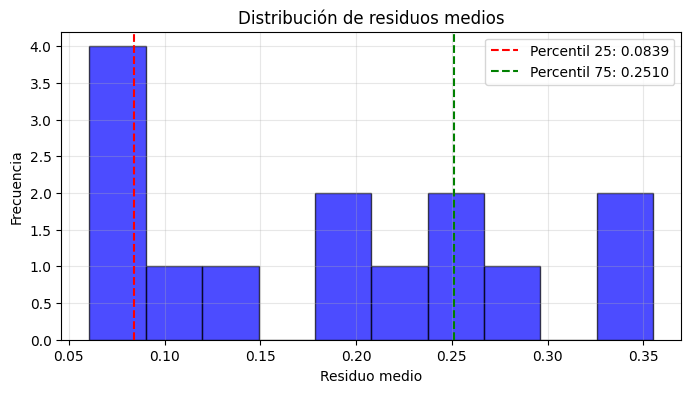

In [ ]:
# Calcular residuos medios
mean_residues = compute_mean_residues(processor, file_paths)

# Graficar la distribución
plot_mean_residues_distribution(mean_residues)


In [ ]:
def compute_desalineacion_probability(residues: np.ndarray, lower_threshold: float, upper_threshold: float) -> np.ndarray:
    """
    Calcula la probabilidad de desalineación para cada punto en 'residues' usando los umbrales dados.

    Para cada valor en 'residues':
      - Si el residuo <= lower_threshold, la probabilidad es 0 (totalmente desbalanceo).
      - Si el residuo >= upper_threshold, la probabilidad es 1 (totalmente desalineación).
      - En caso intermedio, se interpola linealmente:
            p = (residuo - lower_threshold) / (upper_threshold - lower_threshold)

    Args:
        residues (np.ndarray): Vector 1D de residuos (ya escalados).
        lower_threshold (float): Umbral inferior.
        upper_threshold (float): Umbral superior.

    Returns:
        np.ndarray: Vector 1D de probabilidades de desalineación.
    """
    p = np.zeros_like(residues, dtype=float)
    p[residues <= lower_threshold] = 0.0
    p[residues >= upper_threshold] = 1.0
    mask = (residues > lower_threshold) & (residues < upper_threshold)
    p[mask] = (residues[mask] - lower_threshold) / (upper_threshold - lower_threshold)
    return p

### Presentación de resultados

In [ ]:
def graficar_ajuste_con_percentiles(
    ruta_archivo: str,
    lower_threshold: float,
    upper_threshold: float,
    report_file: Optional[str] = None
):
    """
    Grafica el ajuste polinómico usando un modelo preentrenado y, para cada columna de desplazamiento,
    calcula la probabilidad de desalineación de cada punto (usando interpolación lineal entre lower_threshold
    y upper_threshold). Se imprime la probabilidad global (promedio) para cada columna y se genera un reporte.

    Args:
        ruta_archivo (str): Ruta al archivo CSV con datos.
        lower_threshold (float): Umbral inferior para la interpolación.
        upper_threshold (float): Umbral superior para la interpolación.
        report_file (str, optional): Ruta para guardar el reporte en CSV.
    """
    # Cargar el ajuste preentrenado (best fit) sin reentrenar.
    processor = DataResidualsProcessor.load("modelo_mejor_fit.pkl")

    # Calcular residuos usando el ajuste preentrenado.
    residuos, columnas, kph, datos_originales, predicciones = processor.calculate_residuals_global(ruta_archivo=ruta_archivo)
    nombre_archivo = ruta_archivo.split('/')[-1]
    print(f"Forma de residuos calculados: {residuos.shape}")
    print(f"Columnas: {columnas}")

    # Convertir kph a vector 1D
    if kph.ndim != 2 or kph.shape[1] != 1:
        raise ValueError("KPH debe ser un arreglo (n, 1).")
    kph = kph.flatten()

    # Ordenar los datos por KPH (de mayor a menor) para graficar de forma ordenada
    order = np.argsort(kph)[::-1]
    kph_sorted = kph[order]
    datos_sorted = datos_originales[order, :]
    predicciones_sorted = predicciones[order, :]

    # Calcular la matriz de residuos absolutos (sin aplanar, se conserva la forma original)
    residuos_abs = np.abs(residuos)  # forma: (n_samples, n_columnas)
    n_columns = residuos_abs.shape[1]

    # Para cada columna, calcular la probabilidad de desalineación y obtener su promedio
    p_desalineacion_cols = {}
    p_desbalanceo_cols = {}
    for i, col in enumerate(columnas):
        # Extraer la columna de residuos escalados
        col_res = residuos_abs[:, i]
        # Calcular la probabilidad para cada punto en esa columna
        p_d = compute_desalineacion_probability(col_res, lower_threshold, upper_threshold)
        # Guardar el promedio para la columna
        p_desalineacion_cols[col] = p_d.mean()
        p_desbalanceo_cols[col] = 1.0 - p_desalineacion_cols[col]
        print(f"Columna {col}: P(Desalineación) = {p_desalineacion_cols[col]:.4f}, P(Desbalanceo) = {p_desbalanceo_cols[col]:.4f}")

    # Para el reporte global, también podemos calcular promedios a nivel de todo el archivo (si se desea)
    p_desalineacion_global = np.mean([val for val in p_desalineacion_cols.values()])
    p_desbalanceo_global = 1.0 - p_desalineacion_global
    print(f"\nProbabilidad global de desalineación: {p_desalineacion_global:.4f}")
    print(f"Probabilidad global de desbalanceo: {p_desbalanceo_global:.4f}")

    # Crear DataFrame de reporte con información de cada sensor y agregar los promedios por columna
    data_dict = {'KPH': kph_sorted}
    for i, col in enumerate(columnas):
        data_dict[f'Amplitud ({col})'] = datos_sorted[:, i]
        data_dict[f'Predicción ({col})'] = predicciones_sorted[:, i]
        data_dict[f'|Residuo| ({col})'] = np.abs(datos_sorted[:, i] - predicciones_sorted[:, i])
        data_dict[f'P(Desalineación) Global ({col})'] = p_desalineacion_cols[col]
        data_dict[f'P(Desbalanceo) Global ({col})'] = p_desbalanceo_cols[col]

    df = pd.DataFrame(data_dict)
    # Se puede agregar también el residuo medio total (por archivo)
    df['ResiduoMedioArchivo'] = residuos_abs.mean()

    print("\nReporte de probabilidades (primeras 10 filas):")
    print(df.head(10))

    if report_file:
        df.to_csv(report_file, index=False)
        print(f"Reporte completo guardado en: {report_file}")

    # Graficar: para cada columna se muestra la curva de ajuste y los datos reales
    plt.figure(figsize=(12, 6 * n_columns))
    for i, col in enumerate(columnas):
        plt.subplot(n_columns, 1, i + 1)
        diferencia = np.abs(datos_sorted[:, i] - predicciones_sorted[:, i])

        scatter = plt.scatter(
            kph_sorted,
            datos_sorted[:, i],
            c=diferencia,
            cmap='viridis',
            alpha=0.7,
            s=50,
            label=f"Datos reales ({col})"
        )
        plt.colorbar(scatter, label="|Residuo|")
        plt.plot(
            kph_sorted,
            predicciones_sorted[:, i],
            color='red',
            label='Ajuste polinómico (grado 3)',
            linewidth=2
        )
        plt.fill_between(
            kph_sorted,
            predicciones_sorted[:, i],
            datos_sorted[:, i],
            color='gray',
            alpha=0.3,
            label='Diferencia (ruido)'
        )
        plt.xlabel('KPH (velocidad)')
        plt.ylabel(f'Amplitud ({col})')
        plt.title(f'{col} en {nombre_archivo} - P(Desalineación) = {p_desalineacion_cols[col]:.4f}')
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)
        y_min = min(datos_sorted[:, i].min(), predicciones_sorted[:, i].min()) * 1.1
        y_max = max(datos_sorted[:, i].max(), predicciones_sorted[:, i].max()) * 1.1
        plt.ylim(y_min, y_max)
    plt.tight_layout()
    plt.show()


In [ ]:
# Calcular automáticamente los umbrales a partir de la distribución de residuos medios
lower_thresh, upper_thresh = compute_thresholds_from_files(file_paths, processor, lower_percentile=25, upper_percentile=75)

Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Lower threshold (percentile 25%): 0.0839
Upper threshold (percentile 75%): 0.2510


In [ ]:
thresholds = {
    'lower_threshold': lower_thresh,
    'upper_threshold': upper_thresh
}

df_thresholds = pd.DataFrame([thresholds])  # Convertir a DataFrame
df_thresholds.to_csv('thresholds.csv', index=False)  # Exportar a CSV
print("Thresholds exportados a thresholds.csv")

Thresholds exportados a thresholds.csv


In [ ]:
# Calcular automáticamente los umbrales a partir de la distribución de residuos medios
lower_thresh, upper_thresh = compute_thresholds_from_files(file_paths, processor, lower_percentile=10, upper_percentile=80)

Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Usando el modelo de referencia del sensor: CSL
Lower threshold (percentile 10%): 0.0671
Upper threshold (percentile 80%): 0.2667


In [ ]:
file_paths[9]

'/content/drive/MyDrive/desbalanceo/data_processed/4_arranqueParadaDesblnCSLCSPCTP_procesado.csv'

Usando el modelo de referencia del sensor: CSL
Forma de residuos calculados: (319, 6)
Columnas: ['CGSX', 'CGSY', 'CGIX', 'CGIY', 'CGTX', 'CGTY']
Columna CGSX: P(Desalineación) = 0.3238, P(Desbalanceo) = 0.6762
Columna CGSY: P(Desalineación) = 0.6668, P(Desbalanceo) = 0.3332
Columna CGIX: P(Desalineación) = 0.1277, P(Desbalanceo) = 0.8723
Columna CGIY: P(Desalineación) = 0.0620, P(Desbalanceo) = 0.9380
Columna CGTX: P(Desalineación) = 0.0450, P(Desbalanceo) = 0.9550
Columna CGTY: P(Desalineación) = 0.2590, P(Desbalanceo) = 0.7410

Probabilidad global de desalineación: 0.2474
Probabilidad global de desbalanceo: 0.7526

Reporte de probabilidades (primeras 10 filas):
        KPH  Amplitud (CGSX)  Predicción (CGSX)  |Residuo| (CGSX)  \
0  0.908832         0.677996           0.796055          0.118059   
1  0.901231         0.662674           0.781403          0.118730   
2  0.893589         0.628879           0.766881          0.138002   
3  0.885830         0.589566           0.752346     

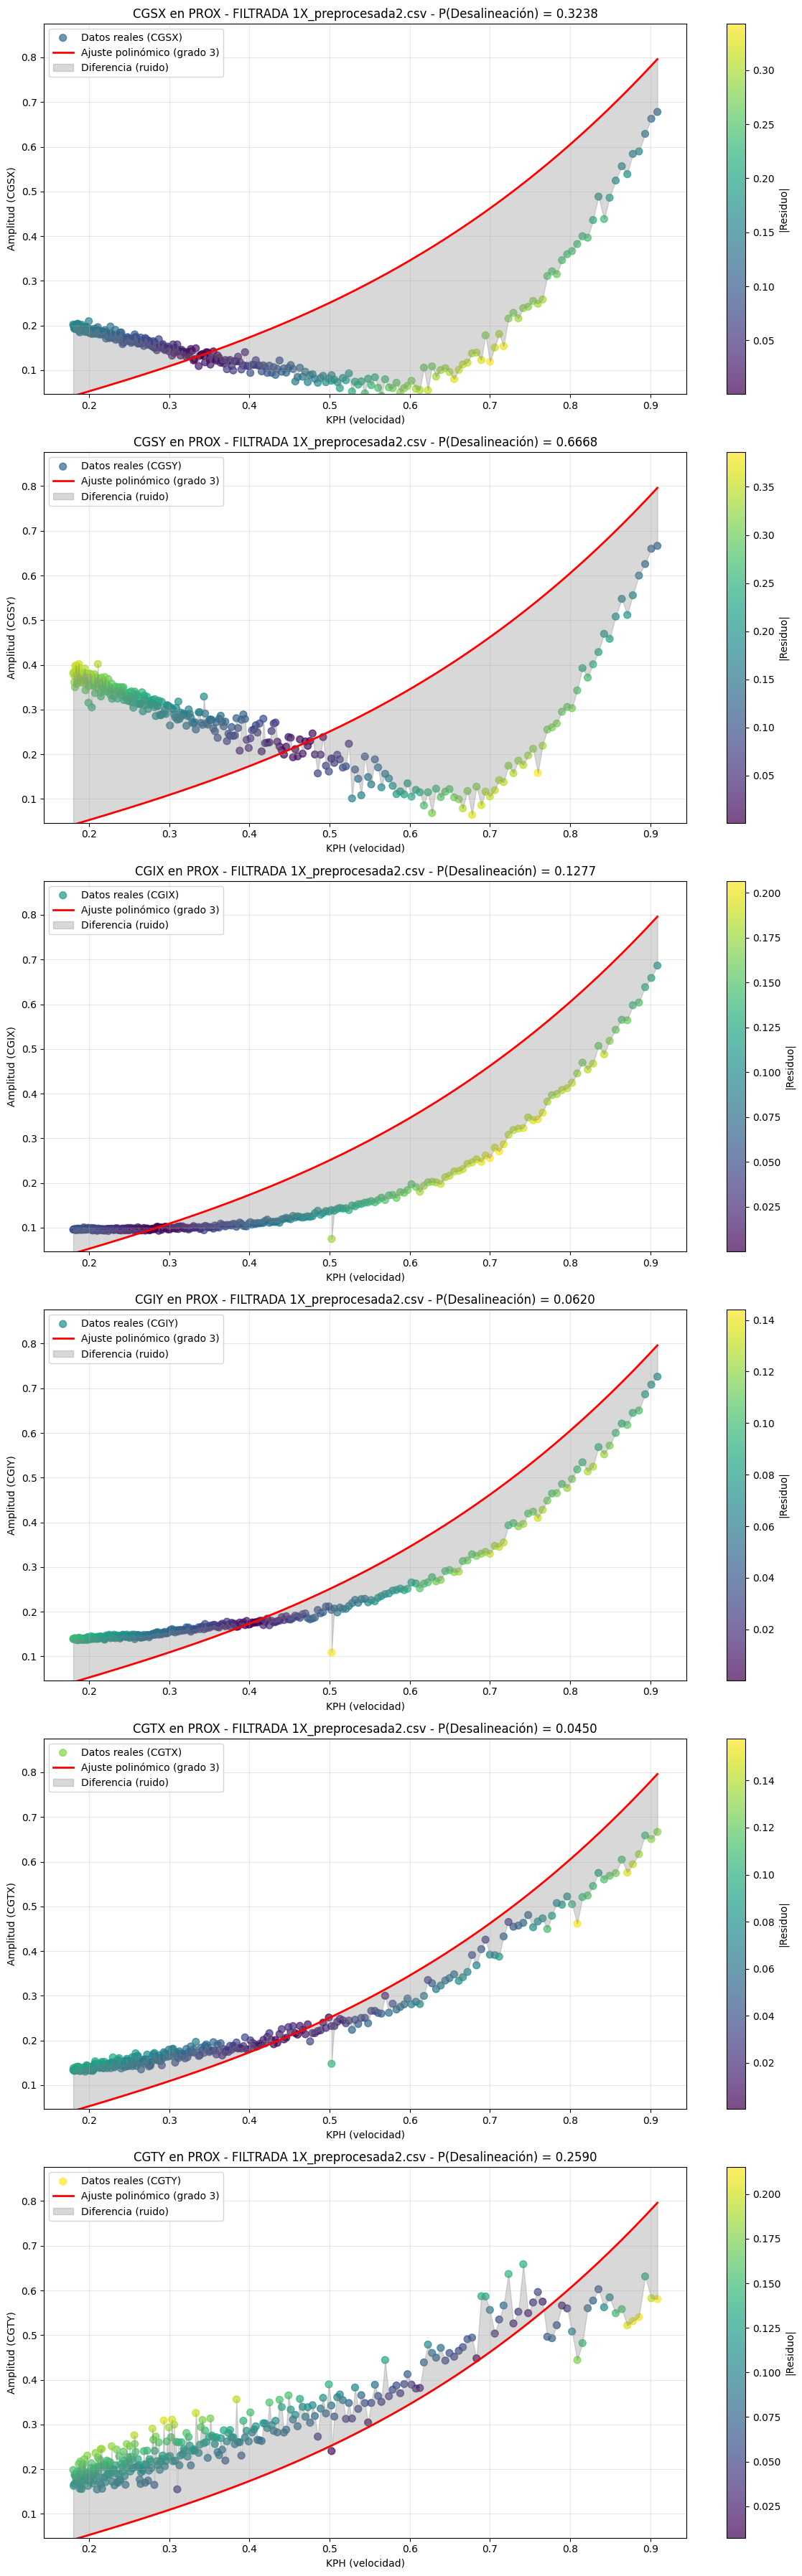

In [ ]:
# Graficar las predicciones
test_file = '/content/drive/MyDrive/tests/PROX - FILTRADA 1X_preprocesada2.csv'

desln_file = '/content/drive/MyDrive/desalineacion/data_processed/7_arranqueParadaDesln_procesado.csv'
# graficar_ajuste_con_percentiles(desln_file, lower_thresh, upper_thresh, report_file="reporte.csv")
graficar_ajuste_con_percentiles(test_file, lower_thresh, upper_thresh, report_file="reporte.csv")
# graficar_ajuste_con_percentiles(file_paths[13], lower_thresh, upper_thresh, report_file="reporte.csv")

Usando el modelo de referencia del sensor: CSL
Forma de residuos calculados: (2778, 4)
Columnas: ['C1X', 'C1Y', 'C2X', 'C2Y']
Columna C1X: P(Desalineación) = 0.9556, P(Desbalanceo) = 0.0444
Columna C1Y: P(Desalineación) = 0.9549, P(Desbalanceo) = 0.0451
Columna C2X: P(Desalineación) = 0.9570, P(Desbalanceo) = 0.0430
Columna C2Y: P(Desalineación) = 0.9582, P(Desbalanceo) = 0.0418

Probabilidad global de desalineación: 0.9564
Probabilidad global de desbalanceo: 0.0436

Reporte de probabilidades (primeras 10 filas):
        KPH  Amplitud (C1X)  Predicción (C1X)  |Residuo| (C1X)  \
0  1.000000        1.000000          0.988512         0.011488   
1  0.999222        0.999935          0.986734         0.013201   
2  0.998640        0.998036          0.985405         0.012632   
3  0.997961        0.998065          0.983857         0.014208   
4  0.997090        0.997761          0.981873         0.015888   
5  0.996704        0.997061          0.980993         0.016067   
6  0.996028        

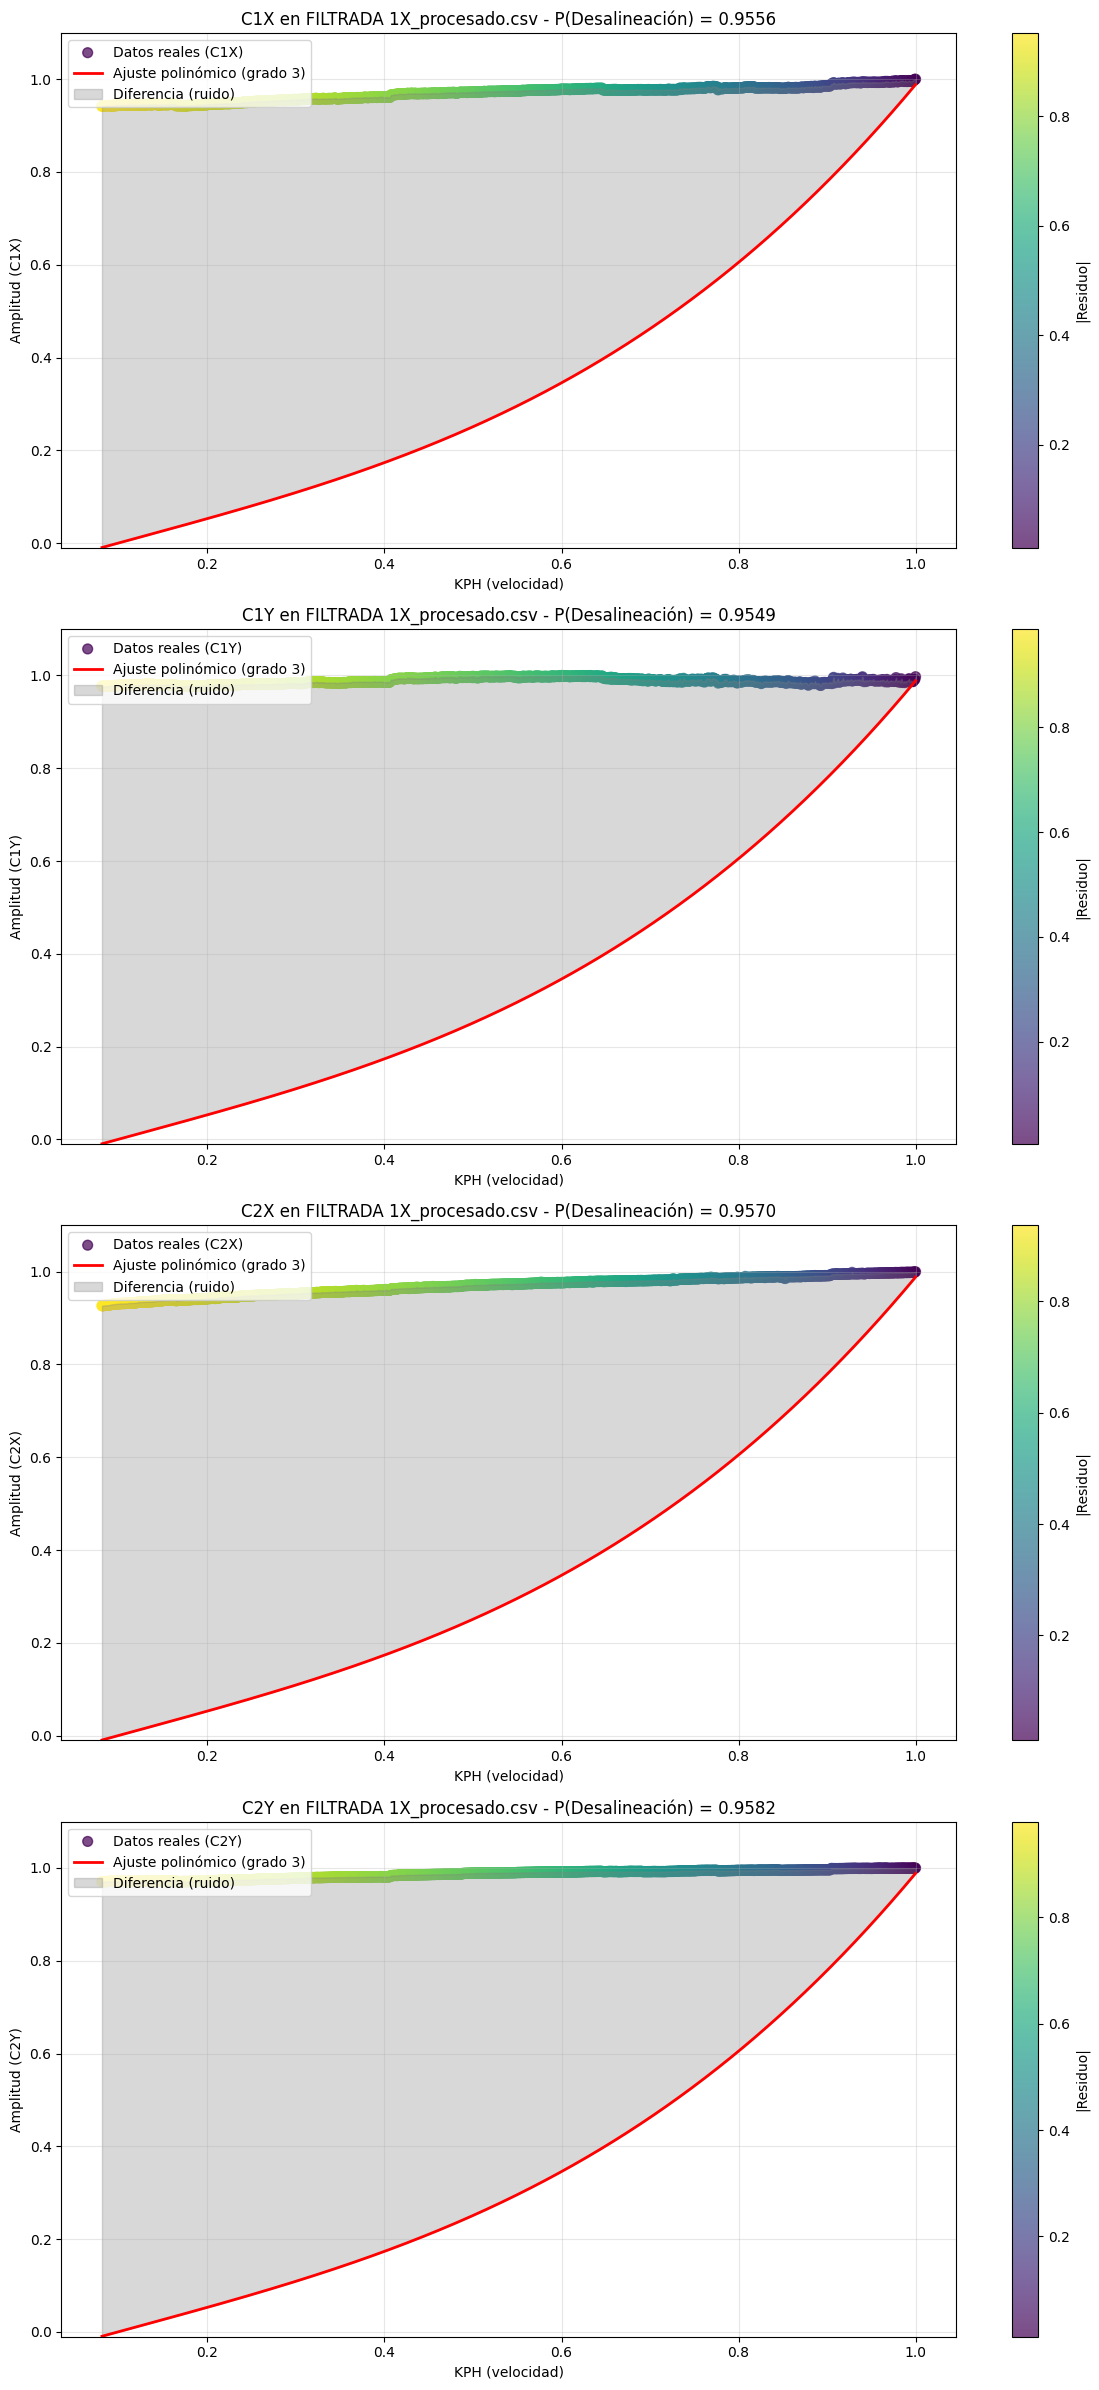

In [ ]:
test_file_two = '/content/drive/MyDrive/tests/FILTRADA 1X_procesado.csv'
graficar_ajuste_con_percentiles(test_file_two, lower_thresh, upper_thresh, report_file="reporte.csv")

Usando el modelo de referencia del sensor: CSL
Forma de residuos calculados: (322, 4)
Columnas: ['CLEX', 'CLEY', 'CLAX', 'CLAY']
Columna CLEX: P(Desalineación) = 0.2698, P(Desbalanceo) = 0.7302
Columna CLEY: P(Desalineación) = 0.7537, P(Desbalanceo) = 0.2463
Columna CLAX: P(Desalineación) = 0.9728, P(Desbalanceo) = 0.0272
Columna CLAY: P(Desalineación) = 0.9569, P(Desbalanceo) = 0.0431

Probabilidad global de desalineación: 0.7383
Probabilidad global de desbalanceo: 0.2617

Reporte de probabilidades (primeras 10 filas):
        KPH  Amplitud (CLEX)  Predicción (CLEX)  |Residuo| (CLEX)  \
0  0.969826         0.992105           0.921298          0.070807   
1  0.951820         0.865318           0.882875          0.017558   
2  0.933208         0.806944           0.844449          0.037504   
3  0.915294         0.797948           0.808674          0.010726   
4  0.897473         0.742286           0.774235          0.031949   
5  0.880476         0.705659           0.742439          0.0

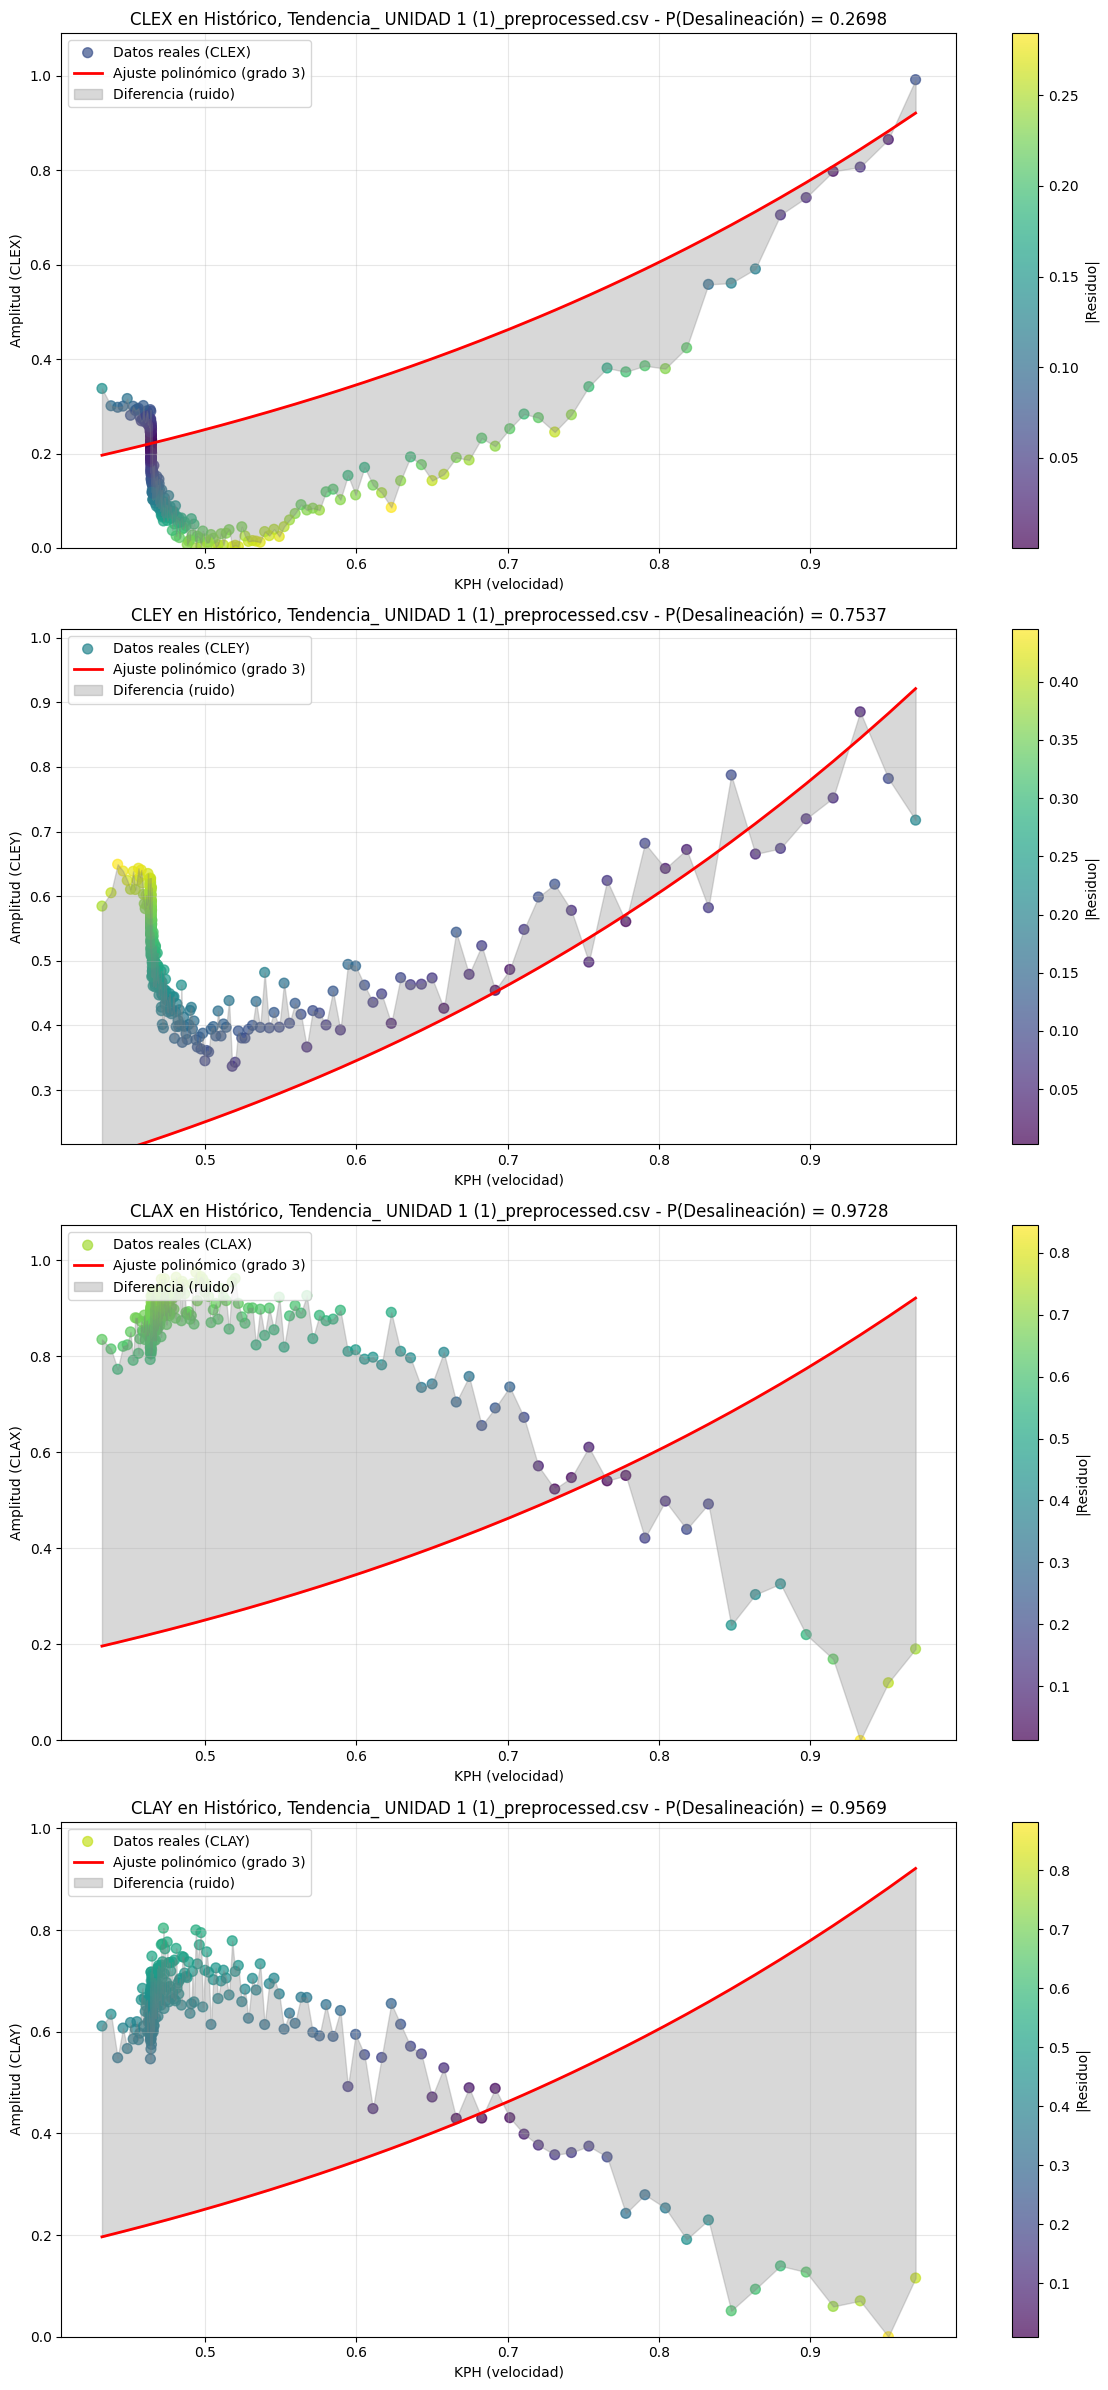

In [ ]:
test_file_three = '/content/drive/MyDrive/tests/Histórico, Tendencia_ UNIDAD 1 (1)_preprocessed.csv'
graficar_ajuste_con_percentiles(test_file_three, lower_thresh, upper_thresh, report_file="reporte.csv")

Usando el modelo de referencia del sensor: CSL
Forma de residuos calculados: (848, 6)
Columnas: ['CTLX', 'CTLY', 'CGAX', 'CGAY', 'CTAX', 'CTAY']
Columna CTLX: P(Desalineación) = 0.9853, P(Desbalanceo) = 0.0147
Columna CTLY: P(Desalineación) = 0.9591, P(Desbalanceo) = 0.0409
Columna CGAX: P(Desalineación) = 0.9294, P(Desbalanceo) = 0.0706
Columna CGAY: P(Desalineación) = 0.9115, P(Desbalanceo) = 0.0885
Columna CTAX: P(Desalineación) = 0.7157, P(Desbalanceo) = 0.2843
Columna CTAY: P(Desalineación) = 0.3489, P(Desbalanceo) = 0.6511

Probabilidad global de desalineación: 0.8083
Probabilidad global de desbalanceo: 0.1917

Reporte de probabilidades (primeras 10 filas):
        KPH  Amplitud (CTLX)  Predicción (CTLX)  |Residuo| (CTLX)  \
0  0.944564         0.992207           0.867739          0.124467   
1  0.941839         0.988733           0.862106          0.126627   
2  0.939304         0.990578           0.856891          0.133687   
3  0.936609         0.987614           0.851374     

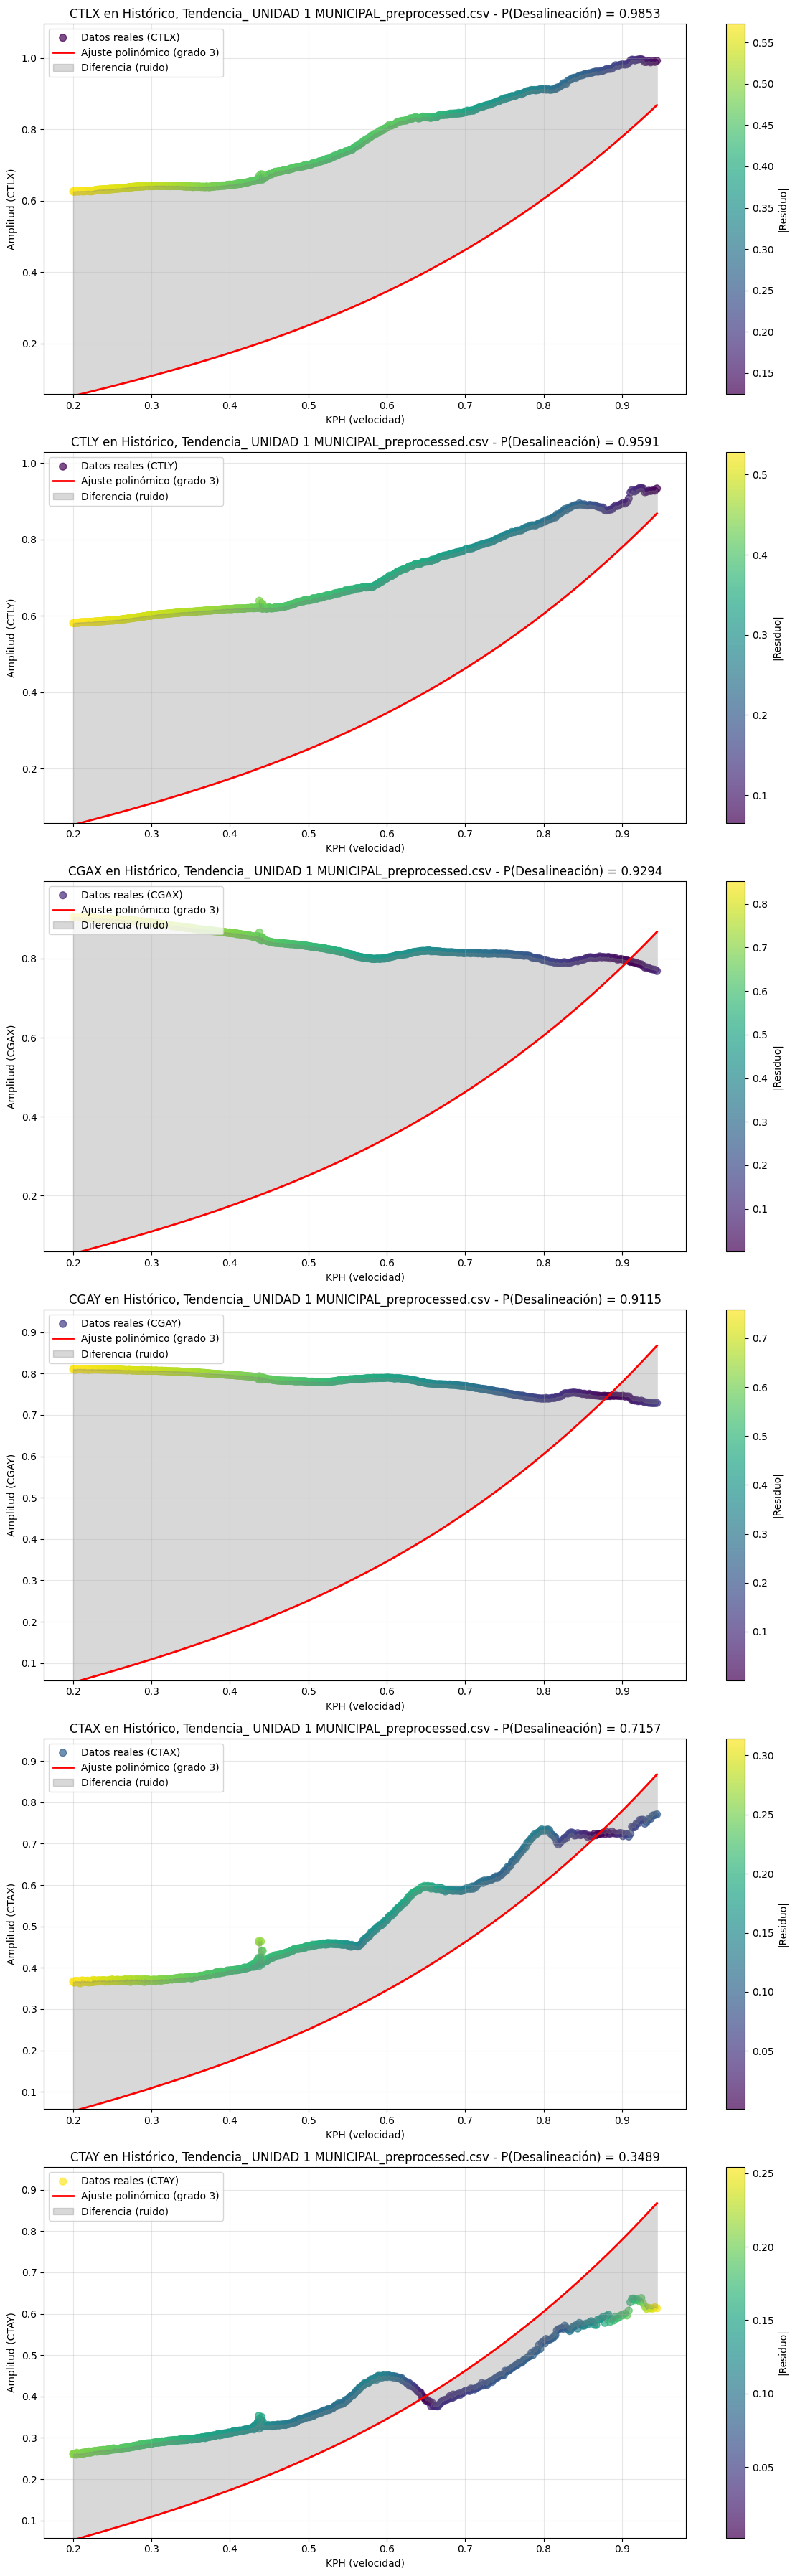

In [ ]:
test_file_four = '/content/drive/MyDrive/tests/Histórico, Tendencia_ UNIDAD 1 MUNICIPAL_preprocessed.csv'
graficar_ajuste_con_percentiles(test_file_four, lower_thresh, upper_thresh, report_file="reporte.csv")